In [1]:
import numpy as np
import pandas as pd
import data_lib
import plot_lib
import decision_lib
from sklearn import cluster, mixture
import validation_lib
import transform_lib

np.random.seed(200)

In [2]:
# print available data summary
_ = data_lib.explore_datasets(datafolder="../../Data",verbose=True)
print(data_lib.LABELS_LIST)

----------------------------------------------------------------------------------------------
-- The following 4 groups were found
-- They contain 40 datasets
-- The first printed entity is the key to the returned dictionary
-----------------------------------
Group: ../../Data/6P-positive-dilution-series-2-labelled/droplet-level-data/RawData
po-di-se-2-A4, files: 13                po-di-se-2-C4, files: 13                po-di-se-2-A1, files: 13
po-di-se-2-B1, files: 13                po-di-se-2-D1, files: 13                po-di-se-2-B4, files: 13
po-di-se-2-C1, files: 13                po-di-se-2-D4, files: 13                
-----------------------------------
Group: ../../Data/6P-positive-dilution-series-1-labelled/droplet-level-data/RawData
po-di-se-1-D4, files: 13                po-di-se-1-A4, files: 13                po-di-se-1-A1, files: 13
po-di-se-1-D1, files: 13                po-di-se-1-B1, files: 13                po-di-se-1-C1, files: 13
po-di-se-1-B4, files: 13         

### Get samples for negative control

In [3]:

# load the necessary datasetes
df_di = data_lib.load_dataset(None, [
    "po-di-se-2-A4", "po-di-se-2-B1", "po-di-se-2-C1", "po-di-se-2-C4",
    "po-di-se-2-D1", "po-di-se-2-D4", "po-di-se-2-A1", "po-di-se-2-B4",

    "po-di-se-1-D4", "po-di-se-1-D1", "po-di-se-1-B4", "po-di-se-1-A4",
    "po-di-se-1-B1", "po-di-se-1-C4", "po-di-se-1-A1", "po-di-se-1-C1",

    "po-di-se-B8", "po-di-se-D8", "po-di-se-A8", "po-di-se-C8",
                                     ], 
                              datafolder="../../Data")


df_negative_control = data_lib.load_dataset([],[
    "po-di-se-1-D1", "po-di-se-1-D4",
    "po-di-se-2-D1", "po-di-se-2-D4",
    "po-di-se-D8",
                                                ], 
                                            datafolder="../../Data")
# Everything is positive contol
df_positive_control = df_di.iloc[:,:6]

# convert to numpy
np_di = df_di.to_numpy(copy=True)[:,:6]
np_negative_control = df_negative_control.to_numpy()

In [4]:
# fix clustering algorithm
prediction_axis = ['SARS-N2_POS','SARS-N1_POS','IBV-M_POS','RSV-N_POS','IAV-M_POS','MHV_POS']
#cluster_engine = cluster.DBSCAN(eps=700, n_jobs=4, min_samples=6, leaf_size=5)
whitening_engine = transform_lib.WhitenTransformer()
num_cluster = int(2**len(prediction_axis) * 2)
cluster_engine = cluster.KMeans(n_clusters=num_cluster, n_init='auto')
#cluster_engine = mixture.GaussianMixture(n_components=100)
decision = decision_lib.ClusterHierarchyDensityClassifier(
                                     negative_control=np_negative_control,
                                     cluster_algorithm=cluster_engine,
                                     whitening_transformer=whitening_engine,
                                     eps=0.25,
                                     contamination=0.004,
                                     density_quantile=0.05,
                                     prediction_axis=prediction_axis,
                                     )
df_decision = decision.predict(np_di, verbose=True)

Time to remove Negatives: 0.009275197982788086 seconds.
Time for Clustering: 2.8639228343963623 seconds.
Time for Whitening: 0.0393829345703125 seconds.
Time for Cluster Features: 0.5884482860565186 seconds.
Time for Predictions: 0.3772921562194824 seconds.
Time for Cluster Features (2): 0.4419291019439697 seconds.
Time to build Density estimation: 3.29937744140625 seconds.
Time to compute point probabilies: 2.593140125274658 seconds.


## Plot the predictions

- Black = True negative prediction
- Green = True positive prediciton
- Purple = False negative
- Red = False positive
- yellow = outlier

#### Plot for all diseases predictions against ground truth

Firs plot is in the decorrelated coordinates, whereas the second is in original coordinates

Outlier rate: 0.0011127094783175342, n_outlier: 543

Total error rate: 0.0015739978837520155
 SARS-N2_POS  SARS-N1_POS  IBV-M_POS  RSV-N_POS  IAV-M_POS  MHV_POS
    0.000251     0.002356    0.00118   0.003355   0.000412  0.00189

Precision (TP / (TP + FP)): 0.9979273676872253
 SARS-N2_POS  SARS-N1_POS  IBV-M_POS  RSV-N_POS  IAV-M_POS  MHV_POS
    0.999219     0.995433    0.99452   0.999673   0.999078 0.999477

Recall / TPR (TP / (TP + FN)): 0.998053789138794
 SARS-N2_POS  SARS-N1_POS  IBV-M_POS  RSV-N_POS  IAV-M_POS  MHV_POS
    0.999925     0.997147   0.998517   0.994192   0.999415 0.999566

Specificity / TNR (TN / (TN + FP)): 0.9997982382774353
 SARS-N2_POS  SARS-N1_POS  IBV-M_POS  RSV-N_POS  IAV-M_POS  MHV_POS
     0.99993     0.999576   0.999464   0.999965   0.999906  0.99995

Accuracy ((TP + TN) / (P + N)): 0.9996435046195984
 SARS-N2_POS  SARS-N1_POS  IBV-M_POS  RSV-N_POS  IAV-M_POS  MHV_POS
     0.99993      0.99937    0.99938   0.999403   0.999861 0.999917

F1 (2 * (precision *

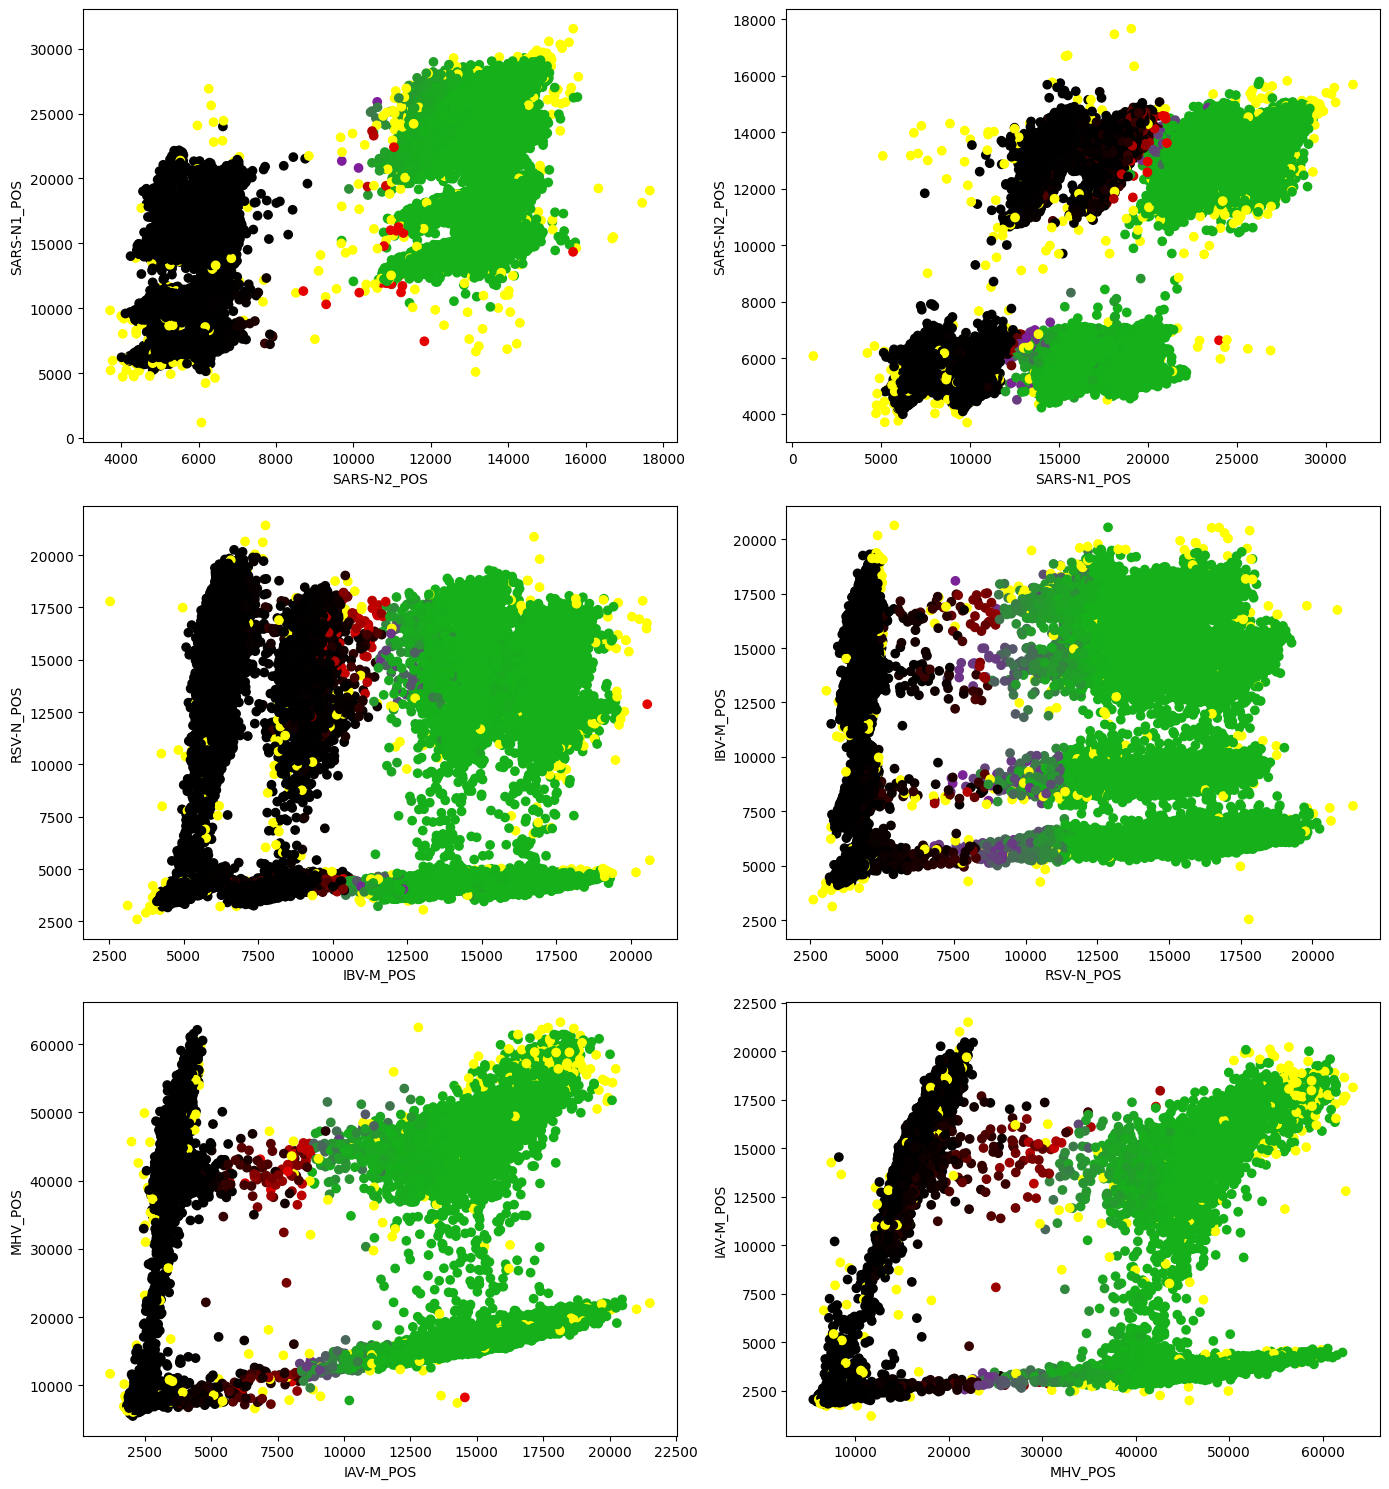

In [5]:

df_data_points = pd.DataFrame(data=decision.X, columns=prediction_axis) 
df_predictions = df_decision
df_ground_trouth = df_di
selected_pairs = [
                ('SARS-N2_POS','SARS-N1_POS'),
                ('SARS-N1_POS','SARS-N2_POS'),
                ('IBV-M_POS','RSV-N_POS'),
                ('RSV-N_POS','IBV-M_POS'),
                ('IAV-M_POS','MHV_POS'),
                ('MHV_POS','IAV-M_POS'),
                ]

mask = decision.No_neg_mask
validation_lib.validate_labels(df_true_labels=df_di, df_predicted_labels=decision.probabilities_df, verbosity=1, threshold=0.5)

plot_lib.plot_pairwise_selection_bayesian(
        df_data_points,
        decision.probabilities_df,
        df_ground_trouth,
        selected_pairs,
        n_cols=2,
        mask=mask,
        )

In [6]:
validation_lib.validate_combinations(df_di, df_decision, verbosity=0)

Total number of outlayer: 543

Label combination ('SARS-N2_POS',):
n outliers: 5, n_true_pos: 7797
Balanced Accuracy: 0.9980731321725149

Label combination ('SARS-N1_POS',):
n outliers: 2, n_true_pos: 8391
Balanced Accuracy: 0.9961492683082593

Label combination ('IBV-M_POS',):
n outliers: 11, n_true_pos: 10180
Balanced Accuracy: 0.99811958235897

Label combination ('RSV-N_POS',):
n outliers: 11, n_true_pos: 9486
Balanced Accuracy: 0.9152481184379013

Label combination ('IAV-M_POS',):
n outliers: 9, n_true_pos: 5742
Balanced Accuracy: 0.9988663953883283

Label combination ('MHV_POS',):
n outliers: 9, n_true_pos: 9145
Balanced Accuracy: 0.9973861816030937

Label combination ('SARS-N2_POS', 'SARS-N1_POS'):
n outliers: 5, n_true_pos: 4261
Balanced Accuracy: 0.9992783036369615

Label combination ('SARS-N2_POS', 'IBV-M_POS'):
n outliers: 2, n_true_pos: 1035
Balanced Accuracy: 0.9994998998710305

Label combination ('SARS-N2_POS', 'RSV-N_POS'):
n outliers: 7, n_true_pos: 1247
Balanced Accurac